<a href="https://colab.research.google.com/github/Ecruzesp/Thesis/blob/main/CNN_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import glob
import cv2 as cv
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Capture images and labels into arrays.
#Start by creating empty lists.
images = []
labels = []
for directory_path in glob.glob("/content/drive/MyDrive/Thesis/Transfer_learning/Kaggle/*"):#"Kaggle/three_classes/*"):
    label = directory_path.split("/")[-1]    
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        #img = cv.resize(img, (256,256), interpolation=cv.INTER_CUBIC)
        images.append(img)
        labels.append(label)
        
images = np.array(images)
labels = np.array(labels)

In [ ]:
#Capture images and labels into arrays.
#Start by creating empty lists.
images_validation = []
labels_validation = []
for directory_path in glob.glob("/content/drive/MyDrive/Thesis/Transfer_learning/Base_Local/*"):
    label = directory_path.split("/")[-1]    
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        #img = cv.resize(img, (256,256), interpolation=cv.INTER_CUBIC)
        images_validation.append(img)
        labels_validation.append(label)
        
images_validation = np.array(images_validation)
labels_validation = np.array(labels_validation)

In [ ]:
images_validation.shape

(45, 128, 128, 3)

In [ ]:
# Encode labels from text (folder names) to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
le.fit(labels_validation)
labels = le.transform(labels)
labels_validation = le.transform(labels_validation)

In [ ]:
X = images
y = labels

In [ ]:
# test_size: what proportion of original data is used for test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [ ]:
#Normalize pixel values to between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
batch_size = 32
img_height = 128
img_width = 128

data_dir = "/content/drive/MyDrive/Thesis/Transfer_learning/Kaggle/"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




Found 1632 files belonging to 3 classes.
Using 1143 files for training.


In [ ]:
data_dir = "/content/drive/MyDrive/Thesis/Transfer_learning/Kaggle/"
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1632 files belonging to 3 classes.
Using 489 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2']


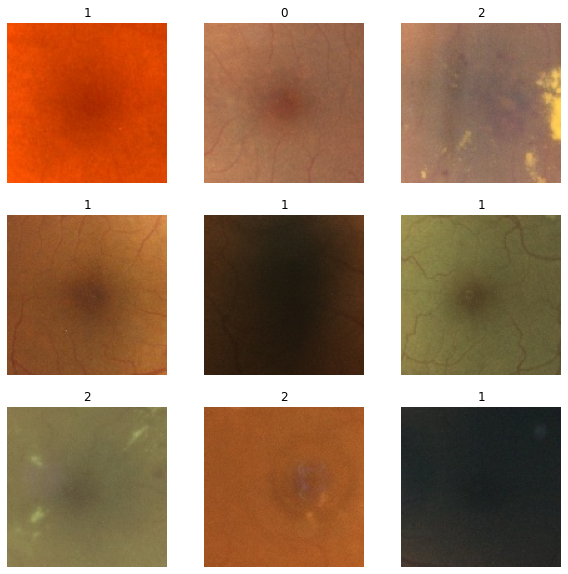

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.10980393 0.67058825


In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='SGD',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
epochs=1000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/1000
36/36 [==============================] - 14s 39ms/step - loss: 1.1004 - accuracy: 0.3342 - val_loss: 1.0982 - val_accuracy: 0.3231
Epoch 2/1000
36/36 [==============================] - 1s 16ms/step - loss: 1.0972 - accuracy: 0.3570 - val_loss: 1.0962 - val_accuracy: 0.3599
Epoch 3/1000
36/36 [==============================] - 0s 14ms/step - loss: 1.0976 - accuracy: 0.3368 - val_loss: 1.0963 - val_accuracy: 0.3783
Epoch 4/1000
36/36 [==============================] - 0s 14ms/step - loss: 1.0967 - accuracy: 0.3605 - val_loss: 1.0973 - val_accuracy: 0.3313
Epoch 5/1000
36/36 [==============================] - 0s 13ms/step - loss: 1.0942 - accuracy: 0.3535 - val_loss: 1.0955 - val_accuracy: 0.3517
Epoch 6/1000
36/36 [==============================] - 0s 14ms/step - loss: 1.0950 - accuracy: 0.3657 - val_loss: 1.0952 - val_accuracy: 0.3906
Epoch 7/1000
36/36 [==============================] - 0s 14ms/step - loss: 1.0938 - accuracy: 0.3640 - val_loss: 1.0944 - val_accuracy: 0.380

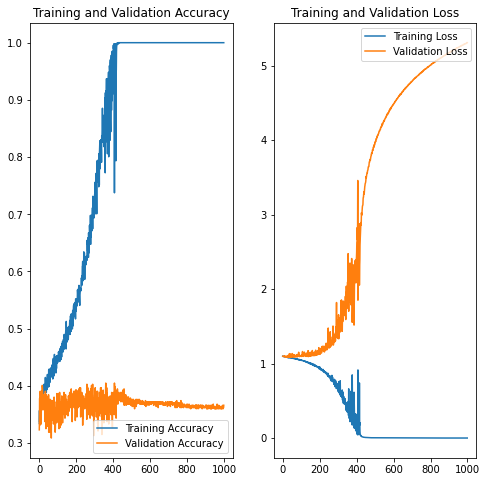

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

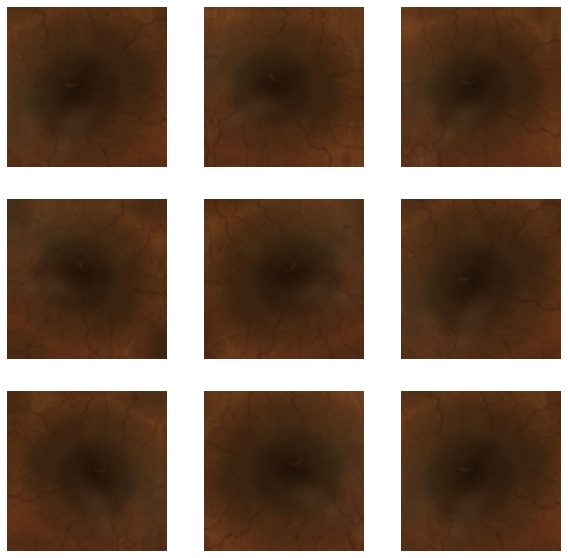

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                 

In [ ]:
epochs = 1000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/1000
36/36 [==============================] - 1s 21ms/step - loss: 0.8438 - accuracy: 0.5862 - val_loss: 1.2717 - val_accuracy: 0.3845
Epoch 2/1000
36/36 [==============================] - 1s 16ms/step - loss: 0.8472 - accuracy: 0.6168 - val_loss: 1.2843 - val_accuracy: 0.3885
Epoch 3/1000
36/36 [==============================] - 1s 16ms/step - loss: 0.8397 - accuracy: 0.6002 - val_loss: 1.3125 - val_accuracy: 0.3783
Epoch 4/1000
36/36 [==============================] - 1s 15ms/step - loss: 0.8331 - accuracy: 0.6054 - val_loss: 1.2521 - val_accuracy: 0.4008
Epoch 5/1000
36/36 [==============================] - 1s 16ms/step - loss: 0.8511 - accuracy: 0.6019 - val_loss: 1.2664 - val_accuracy: 0.3804
Epoch 6/1000
36/36 [==============================] - 1s 16ms/step - loss: 0.8329 - accuracy: 0.6124 - val_loss: 1.2807 - val_accuracy: 0.4008
Epoch 7/1000
36/36 [==============================] - 1s 16ms/step - loss: 0.8208 - accuracy: 0.6037 - val_loss: 1.3266 - val_accuracy: 0.3865

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

In [ ]:
#Capture images and labels into arrays.
#Start by creating empty lists.
images_validation = []
labels_validation = []
for directory_path in glob.glob("/content/drive/MyDrive/Thesis/Transfer_learning/Base_Local/*"):
    label = directory_path.split("/")[-1]    
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        #img = cv.resize(img, (256,256), interpolation=cv.INTER_CUBIC)
        images_validation.append(img)
        labels_validation.append(label)
        
images_validation = np.array(images_validation)
labels_validation = np.array(labels_validation)

i = 44

img = images_validation[i,:,:,:]

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
label_truth = labels_validation[i]
print(label_truth)

This image most likely belongs to 0 with a 46.64 percent confidence.
2
